# SMA-Based Trading Strategy Backtest
This notebook tests a basic momentum trading strategy using 20-day SMA and closing price against the buy-and-hold value of AAPL across 2023.

In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

## Load and Inspect Data

We load historical price data for two assets and perform initial inspection to ensure data quality.

In [8]:
def loadData(code="AAPL", startDate="2023-01-01", endDate="2024-01-01"):
    if startDate > endDate:
        print("Start Date must be before End Date!")
        return None

    startDate = datetime.strptime(startDate, "%Y-%m-%d")
    startDate = startDate - timedelta(days=20) #subtract days to adjust for sma delay
    startDate = startDate.strftime("%Y-%m-%d")

    stock = yf.download(code, start=startDate, end=endDate, progress=False, threads=False)

    if isinstance(stock.columns, pd.MultiIndex):
        stock.columns = stock.columns.droplevel(1)

    if 'Close' not in stock.columns:
        print("Error: 'Close' column is missing. Check the ticker symbol.")
        print(stock.head())
        return None

    stock = stock[["Close"]]
    print(stock.columns)

    if stock.empty:
        print(f"No data found for '{code}'. Check the stock code and date range.")
        return None

    return stock

## Signals
20-Day Simple Moving Average is calculated and added to the dataframe.

In [9]:
def signals(stock):
  stock["SMA_20"] = stock["Close"].rolling(window=20).mean()
  return stock

## Backtest
This strategy goes long when closing price exceeds the SMA, and shorts when it doesn't. Also calculates hold value. These are saved to the dataframe.

Includes transaction fee.

In [10]:
def backtest(stock, currentCash=10000, transactionFee=0.001):
  currentStocksBought = 0
  currentValue = currentCash
  buys = 0
  sells = 0

  holdCash = currentCash
  holdStocksBought = 0
  holdValue = 0
  holding = False

  for date, row in stock.iterrows():
    if pd.isna(row["SMA_20"]) or pd.isna(row["Close"]):
      continue

    currentPrice = row["Close"]

    # passive strategy
    holdValue = holdStocksBought * currentPrice
    stock.loc[date, "Hold_Value"] = holdValue

    # Trading strategy
    sma20 = row["SMA_20"]

    if holding == False:
      holdStocksBought = holdCash / currentPrice
      holdCash = 0
      stock.loc[date, "Hold_Value"] = holdStocksBought * currentPrice
      holding = True

    if currentPrice > sma20:
      if currentCash > 0: # buy
        currentCash -= currentCash * transactionFee
        currentStocksBought = currentCash / currentPrice
        currentCash = 0
        buys += 1
    else:
      if currentStocksBought > 0: # sell
        value = currentStocksBought * currentPrice
        currentCash = value * (1 - transactionFee)
        currentStocksBought = 0
        sells += 1

    assetsValue = currentStocksBought * currentPrice
    currentValue = assetsValue + currentCash
    stock.loc[date, "Portfolio_Value"] = currentValue

  # make sure correct data type
  stock["Portfolio_Value"] = stock["Portfolio_Value"].astype(float)
  stock["Hold_Value"] = stock["Hold_Value"].astype(float)

  print(f"Final portfolio value: ${currentValue:.2f}")
  print(f"Hypothetical hold value: ${holdValue:.2f}")

  return stock

## Performance Evaluation
Graph is plotted to compare the strategy to the buy-and-hold visually, and the final value is shown.

In [11]:
def graph(stock, code="AAPL"):
    print("Final Value: " + str(stock["Portfolio_Value"][-1]))
    fig, ax1 = plt.subplots(figsize=(12, 8))

    # plot first y-axis
    ax1.plot(stock.index, stock["Close"], label=code + " Price", color="blue")
    ax1.plot(stock.index, stock["SMA_20"], label=code + " 20-Day SMA", linestyle="--", color="red")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Price (USD)")
    ax1.legend(loc="upper left") # legend is the label
    ax1.grid(True)

    # second y axis
    ax2 = ax1.twinx()
    ax2.plot(stock.index, stock["Portfolio_Value"], label="Portfolio Value", color="cyan")
    ax2.plot(stock.index, stock["Hold_Value"], label="Hold Value", color="yellow")
    ax2.set_ylabel("Portfolio Value (USD)")
    ax2.legend(loc="upper right")


    plt.title(code + " Strategy vs Hold Comparison")
    plt.show()

## Execution

/tmp/ipython-input-8-503988452.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(code, start=startDate, end=endDate, progress=False, threads=False)
/tmp/ipython-input-11-3436984679.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Initial Value: " + str(stock["Portfolio_Value"][0]))
/tmp/ipython-input-11-3436984679.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Final Value: " + str(stock["Portfolio_Value"][-1]))


MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])
Price            Close
Date                  
2022-12-12  142.642288
2022-12-13  143.609772
Final portfolio value: $14019.81
Hypothetical hold value: $14809.62
Initial Value: nan
Final Value: 14019.812912359404


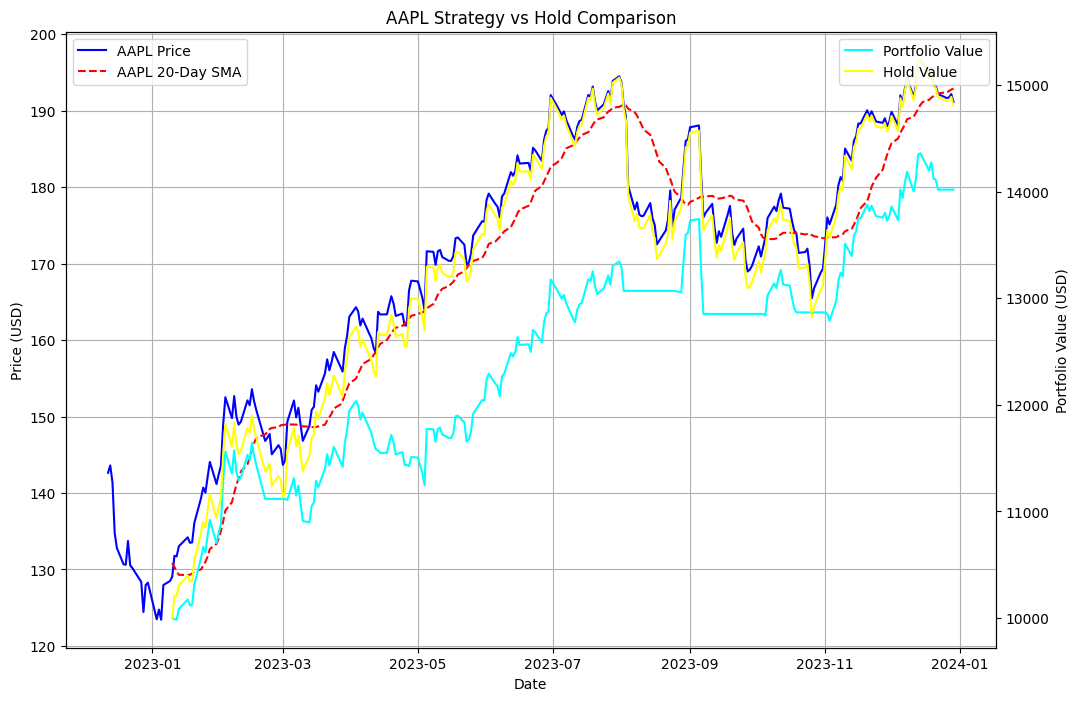

In [12]:
data = loadData()
data = signals(data)
data = backtest(data)
graph(data)


## Conclusion & Reflections/Improvements
This basic momentum strategy shows consistent but limited returns for the upward-trending data of AAPL in 2023, and performs worse on flat stock data. This was my first project and really laid the structural and mental foundations for my future projects.

Improvements:

- handle signal generation in the signals() function, not hard coded in backtest logic; this improves modularity and reusability and readability, and is done in future projects.

- change from a full switch trading system to partial allocation. This is done in my 3rd project (mean reversion vs momentum).

- track more metrics to evaluate the strategy with, such as Total Returns or Sharpe Ratio. This is included in future projects.

- the strategy had sometimes not reacted enough in periods of volatile sharp trends, possibly due to noise around the mean and the full-switch style of investment. In future projects, I explore noise reduction and partial allocation using confirmation lags and tiered signal generation.